Missing Data by Column:
 Age                         0.0
Attrition                   0.0
BusinessTravel              0.0
DailyRate                   0.0
Department                  0.0
DistanceFromHome            0.0
Education                   0.0
EducationField              0.0
EmployeeCount               0.0
EmployeeNumber              0.0
EnvironmentSatisfaction     0.0
Gender                      0.0
HourlyRate                  0.0
JobInvolvement              0.0
JobLevel                    0.0
JobRole                     0.0
JobSatisfaction             0.0
MaritalStatus               0.0
MonthlyIncome               0.0
MonthlyRate                 0.0
NumCompaniesWorked          0.0
Over18                      0.0
OverTime                    0.0
PercentSalaryHike           0.0
PerformanceRating           0.0
RelationshipSatisfaction    0.0
StandardHours               0.0
StockOptionLevel            0.0
TotalWorkingYears           0.0
TrainingTimesLastYear       0.0
WorkLifeBalance

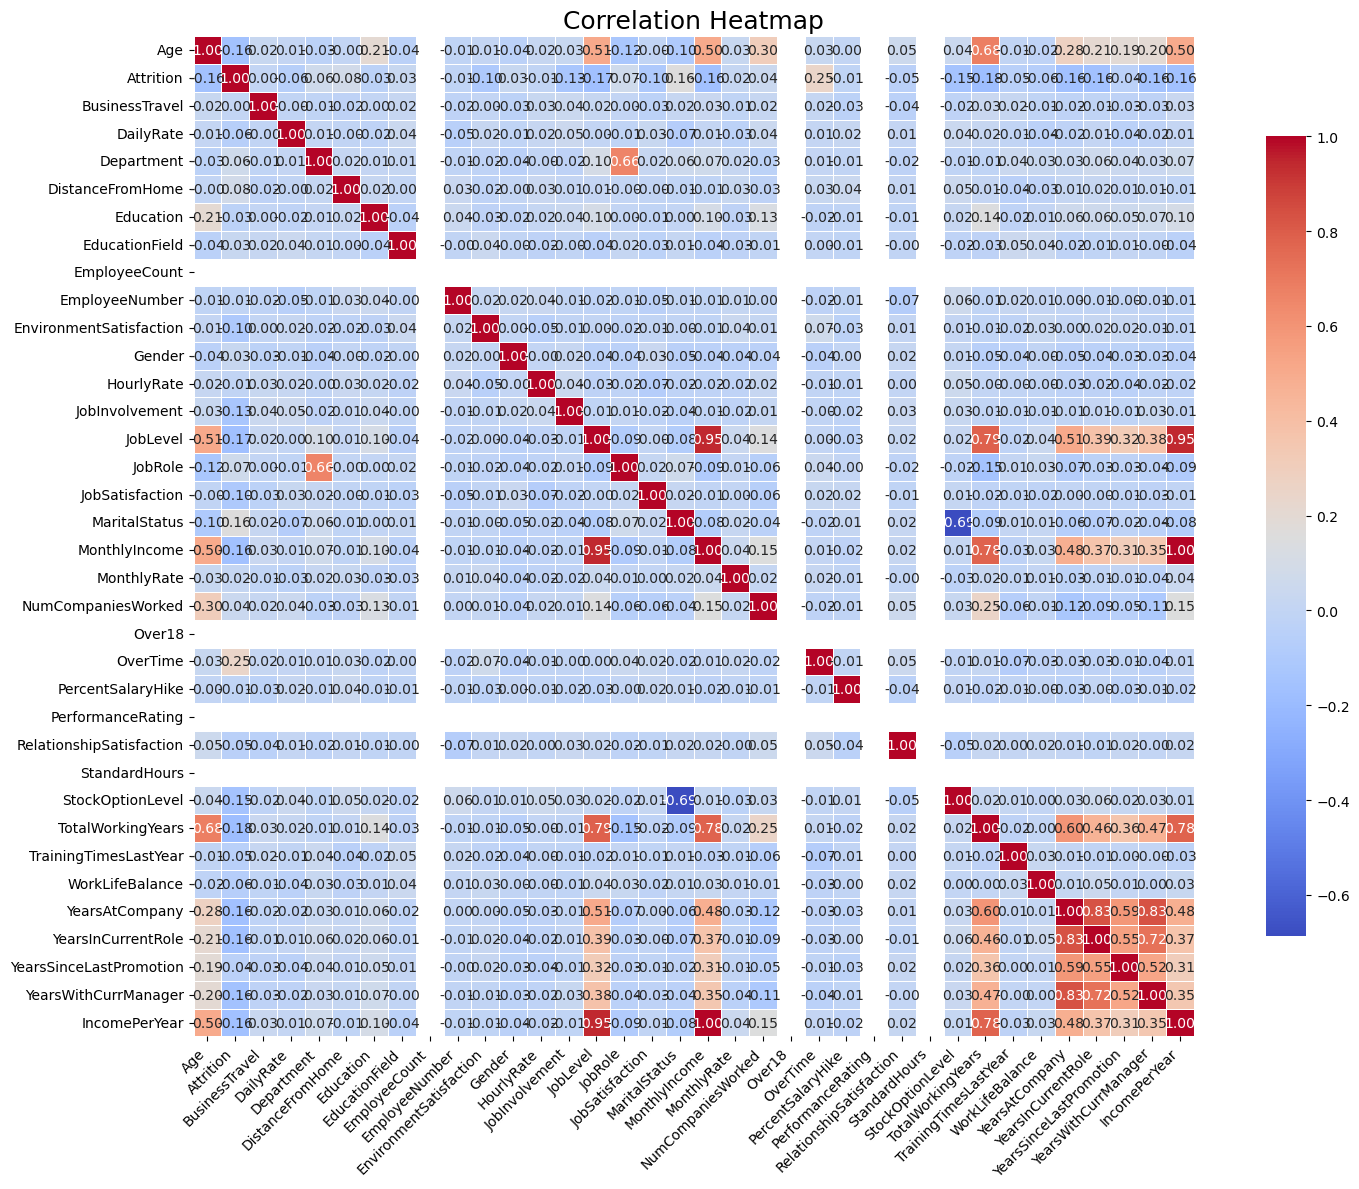

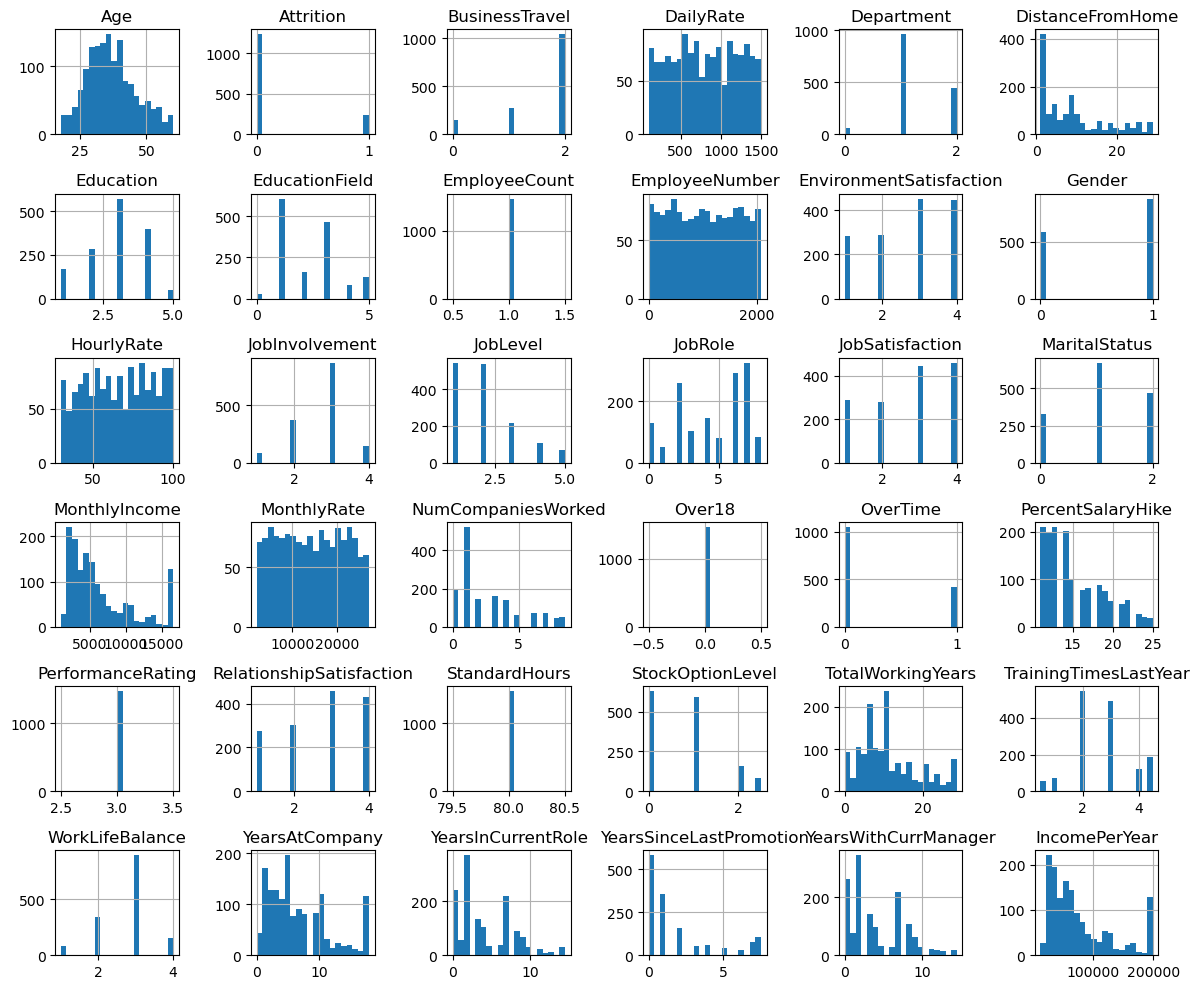

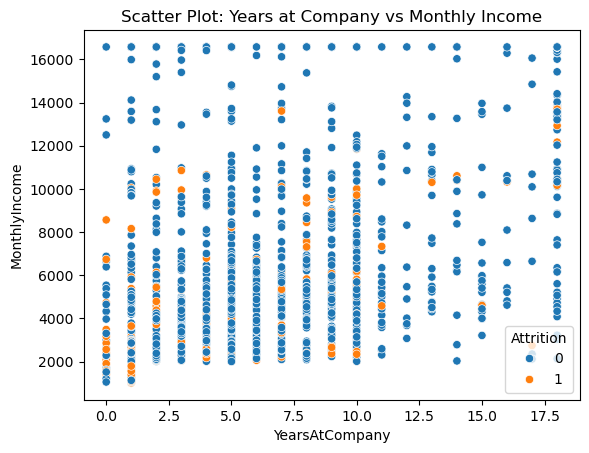

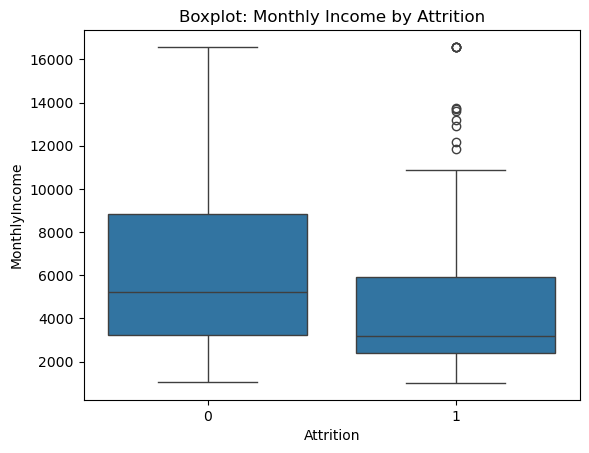

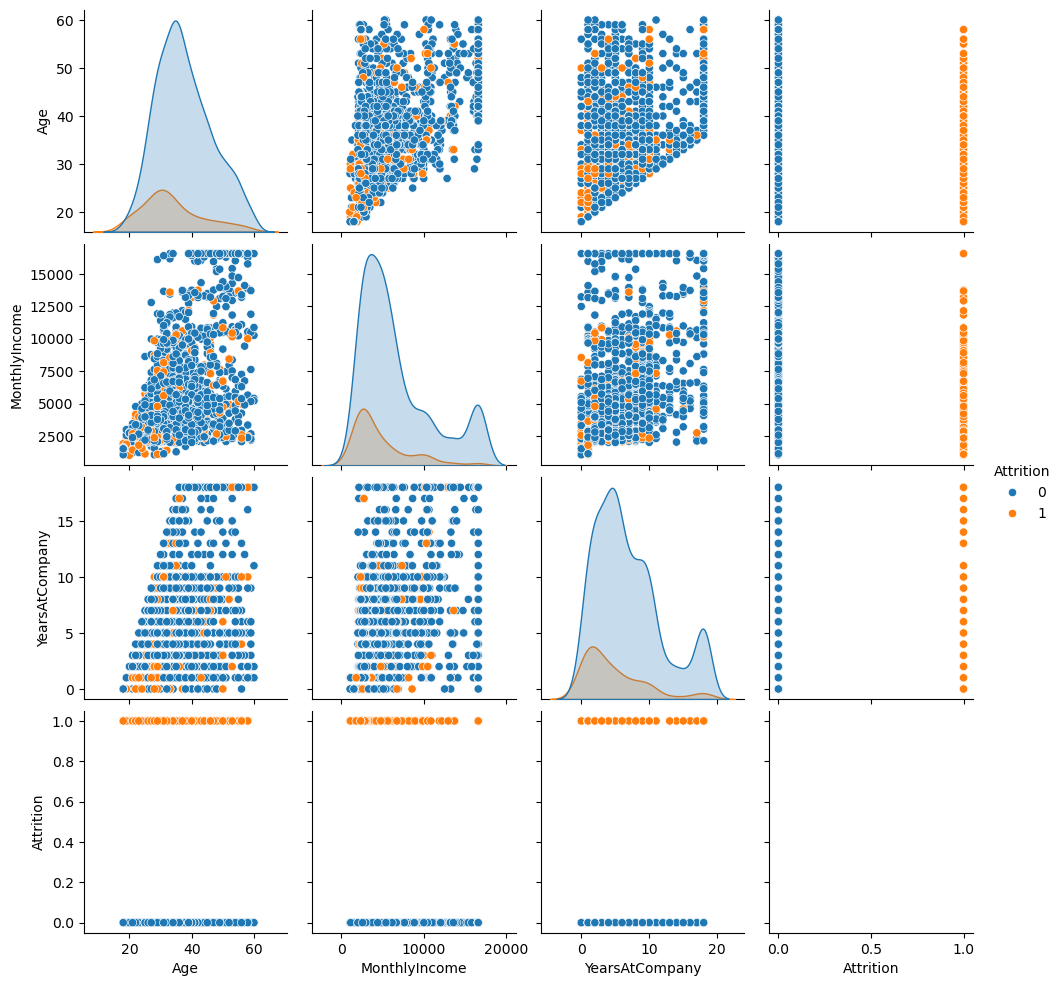

Query 1 Results:
    EmployeeNumber   Age  Gender  MaritalStatus  YearsAtCompany
0             1.0  41.0       0              2             6.0
1             2.0  49.0       1              1            10.0
2             4.0  37.0       1              2             0.0
3             5.0  33.0       0              1             8.0
4             7.0  27.0       1              1             2.0
Query 2 Results:
      AvgIncome
0  5502.277154
Query 3 Results:
    Department  NumEmployees
0           0            63
1           1           961
2           2           446
Query 4 Results:
    EmployeeNumber  JobRole  Department  MonthlyIncome
0             1.0        7           2         5993.0
1             2.0        6           1         5130.0
2             4.0        2           1         2090.0
3             5.0        6           1         2909.0
4             7.0        2           1         3468.0
5             8.0        2           1         3068.0
6            10.0        2    

C:\Users\harik\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
import os

# Set environment variable to avoid KMeans memory issue
os.environ["OMP_NUM_THREADS"] = "6"

# Load the dataset
dataset_path = "/Users/harik/Downloads/EmployeeAttrition.csv"
employee_data = pd.read_csv(dataset_path)

# 1. Handle Missing Data
# Identify missing values
missing_values = employee_data.isnull().sum()
missing_percent = (missing_values / len(employee_data)) * 100
print("Missing Data by Column:\n", missing_percent)

# Impute missing values using KNN Imputer
imputer = KNNImputer(n_neighbors=5)
numerical_data = employee_data.select_dtypes(include=["int64", "float64"])
employee_data[numerical_data.columns] = imputer.fit_transform(numerical_data)

# Detect and Handle Outliers
# Using Z-Score to identify outliers
def detect_outliers_zscore(data, column):
    z_scores = np.abs(stats.zscore(data[column]))
    return data[z_scores > 3]

outlier_columns = numerical_data.columns
for col in outlier_columns:
    outliers = detect_outliers_zscore(employee_data, col)
    if len(outliers) > 0:
        print(f"Outliers detected in {col}: {len(outliers)} rows")

# Cap outliers using IQR
for col in outlier_columns:
    q1 = employee_data[col].quantile(0.25)
    q3 = employee_data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    employee_data[col] = employee_data[col].clip(lower_bound, upper_bound)

# Ensure Data Type Consistency
if "HireDate" in employee_data.columns:
    employee_data["HireDate"] = pd.to_datetime(employee_data["HireDate"], errors='coerce')
categorical_columns = employee_data.select_dtypes(include=["object"]).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col, encoder in label_encoders.items():
    employee_data[col] = encoder.fit_transform(employee_data[col])

# Feature Engineering
employee_data["IncomePerYear"] = employee_data["MonthlyIncome"] * 12
if "HireDate" in employee_data.columns:
    employee_data["YearsSinceHire"] = (pd.Timestamp.now() - employee_data["HireDate"]).dt.days / 365.25

# Drop any remaining datetime columns to avoid ML issues
employee_data = employee_data.select_dtypes(exclude=["datetime64"])

# 2. Exploratory Data Analysis (EDA)
# Cleaned Correlation heatmap
plt.figure(figsize=(16, 12))
correlation_matrix = employee_data.corr()
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={"shrink": 0.8}, 
    square=True, 
    linewidths=0.5, 
    annot_kws={"size": 10}
)
plt.title("Correlation Heatmap", fontsize=18)
plt.xticks(fontsize=10, rotation=45, ha="right")
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Histograms
employee_data.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

# Scatter Plot
sns.scatterplot(x="YearsAtCompany", y="MonthlyIncome", hue="Attrition", data=employee_data)
plt.title("Scatter Plot: Years at Company vs Monthly Income")
plt.show()

# Boxplot
sns.boxplot(x="Attrition", y="MonthlyIncome", data=employee_data)
plt.title("Boxplot: Monthly Income by Attrition")
plt.show()

# Pairplot
sns.pairplot(employee_data, vars=["Age", "MonthlyIncome", "YearsAtCompany", "Attrition"], hue="Attrition")
plt.show()

# Save the cleaned dataset
cleaned_csv_path = "Cleaned_EmployeeAttrition.csv"
employee_data.to_csv(cleaned_csv_path, index=False)

# 3. Relational Database Creation and Normalization
connection = sqlite3.connect("EmployeeAttrition.db")
cursor = connection.cursor()

# Define normalized tables (1NF, 2NF, 3NF)
def create_normalized_tables(df, conn):
    # Employee Table: Stores basic employee details
    employee_df = df[["EmployeeNumber", "Age", "Gender", "MaritalStatus", "YearsAtCompany"]].drop_duplicates()
    employee_df.to_sql("Employee", conn, if_exists="replace", index=False)

    # Job Table: Stores job-related information
    job_df = df[["EmployeeNumber", "JobRole", "JobLevel", "MonthlyIncome", "IncomePerYear"]].drop_duplicates()
    job_df.to_sql("Job", conn, if_exists="replace", index=False)

    # Department Table: Stores department and work-related details
    department_df = df[["EmployeeNumber", "Department", "BusinessTravel", "OverTime"]].drop_duplicates()
    department_df.to_sql("Department", conn, if_exists="replace", index=False)

    # Performance Table: Stores performance-related metrics
    performance_df = df[["EmployeeNumber", "JobSatisfaction", "WorkLifeBalance", "PerformanceRating"]].drop_duplicates()
    performance_df.to_sql("Performance", conn, if_exists="replace", index=False)

    # Compensation Table: Stores salary history and benefit details
    compensation_df = df[["EmployeeNumber", "MonthlyIncome", "StockOptionLevel", "YearsSinceLastPromotion"]].drop_duplicates()
    compensation_df.to_sql("Compensation", conn, if_exists="replace", index=False)

# Normalize and insert data
create_normalized_tables(employee_data, connection)

# Example SQL Queries on Normalized Data
query1 = "SELECT * FROM Employee LIMIT 5;"  # Fetch first 5 employee records
query2 = """
SELECT AVG(MonthlyIncome) AS AvgIncome 
FROM Job 
WHERE JobLevel = 2;
"""  # Calculate average income for job level 2
query3 = """
SELECT Department, COUNT(*) AS NumEmployees 
FROM Department 
GROUP BY Department;
"""  # Count employees in each department
query4 = """
SELECT e.EmployeeNumber, j.JobRole, d.Department, c.MonthlyIncome
FROM Employee e
JOIN Job j ON e.EmployeeNumber = j.EmployeeNumber
JOIN Department d ON e.EmployeeNumber = d.EmployeeNumber
JOIN Compensation c ON e.EmployeeNumber = c.EmployeeNumber
LIMIT 10;
"""  # Join across multiple tables to fetch consolidated information

# Execute and display query results
print("Query 1 Results:\n", pd.read_sql(query1, connection))
print("Query 2 Results:\n", pd.read_sql(query2, connection))
print("Query 3 Results:\n", pd.read_sql(query3, connection))
print("Query 4 Results:\n", pd.read_sql(query4, connection))

connection.close()

# 4. Advanced Data Analysis with Machine Learning
# Splitting data
X = employee_data.drop(columns=["Attrition"])
y = employee_data["Attrition"]

# Standardize the features for Logistic Regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Logistic Regression
logistic_model = LogisticRegression(max_iter=2000)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logistic))

# Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=5)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

# Clustering using KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
employee_data["Cluster"] = kmeans.labels_
print("KMeans Clustering Centroids:\n", kmeans.cluster_centers_)

print("Data cleaning, preprocessing, EDA, SQL integration, normalization, and machine learning completed.")